# Inspect raw data
This notebook can be used to assess how many trials are missing in the EEG data set of one participant.

In [1]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os.path

In [2]:
root_path = "/scratch/data/2024FreeViewingMSCOCO/"

In [3]:
subject_id = 48
padded_subject_id = f"{subject_id:03}"

path = os.path.join(root_path, f"sub-{padded_subject_id}/ses-001/eeg/sub-{padded_subject_id}_ses-001_task-2024FreeViewingMSCOCO_eeg.set")
path_gap = "/scratch/backup/gap_test.set"

#raw = mne.io.read_raw_eeglab(path)
raw = mne.io.read_raw_eeglab(path, preload=True)

/home/schepers/micromamba/envs/FreeViewingMSCOCO/lib/python3.12/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


In [4]:
# raw.plot()

In [5]:
# all_events, all_event_id = mne.events_from_annotations(raw)
# mne.viz.plot_events(events=all_events, event_id=all_event_id, sfreq=raw.info["sfreq"])

## Plot Power Spectral Density (PSD) of the raw data

In [6]:
spectrum = raw.compute_psd()

Effective window size : 2.048 (s)


In [7]:
#frequencies = np.linspace(0.1, 50, 500)
#one_over_f = 1 / frequencies

Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/tmp/ipykernel_1163461/3429505233.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  spectrum.plot(picks=[6]) # single channels
/tmp/ipykernel_1163461/3429505233.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(picks=[6]) # single channels
/home/schepers/micromamba/envs/FreeViewingMSCOCO/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


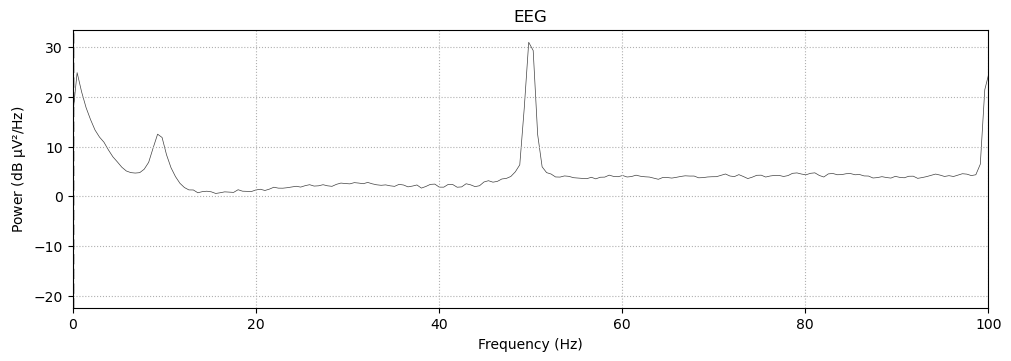

In [8]:
#spectrum.plot(picks="data") # All channnels (+ sample nr)
spectrum.plot(picks=[6]) # single channels
#plt.plot(frequencies, one_over_f, label='1/f Curve', color='blue')
plt.xlim((0,100))
plt.show()

## Find missing data segments in the EEG data

In [9]:
eeg_data = raw.get_data(units="uV")
sample_nr = eeg_data[-1,:] # The last "channel" in the eeg_data is the sample number

In [10]:
def find_missing_data_segments(data):
    start_missing = []
    end_missing = []

    # Check whether first sample is nan (if yes add to start)
    if np.isnan(data[0]):
        start_missing.append(0)
        if (not np.isnan(data[1])):
            end_missing.append(0)
    # Find transitions between existing values and nan-values
    for i in range(1,len(data)-1):
        if (np.isnan(data[i]) and not np.isnan(data[i-1])):
            start_missing.append(i)
        if (np.isnan(data[i]) and not np.isnan(data[i+1])):
            end_missing.append(i)

    # Check whether last sample is nan (if yes add to end)
    if np.isnan(data[-1]):
        end_missing.append(len(data)-1)
        if (not np.isnan(data[-2])):
            start_missing.append(len(data)-1)

    return start_missing, end_missing

In [11]:
start_idx, end_idx = find_missing_data_segments(sample_nr)

In [12]:
missing_segments = pd.DataFrame({
    'start_idx': start_idx,
    'end_idx': end_idx,
    'start_time': raw.times[start_idx],
    'end_time': raw.times[end_idx]})

In [13]:
missing_segments['duration'] = missing_segments['end_time']-missing_segments['start_time']
missing_segments

,start_idx,end_idx,start_time,end_time,duration


## Count number of trials (images shown) within the missing eeg data segments

In [14]:
events = raw.annotations.to_data_frame()

In [15]:
events["onset_seconds"] = events.onset.apply(lambda x: x.timestamp())
events

,onset,duration,description,onset_seconds
0,1970-01-01 00:00:00.696624,0.0,3-128@319684,0.696624
1,1970-01-01 00:00:01.669185,0.0,3-128@320684,1.669185
2,1970-01-01 00:00:02.672457,0.0,3-128@321684,2.672457
3,1970-01-01 00:00:03.675245,0.0,3-128@322684,3.675245
4,1970-01-01 00:00:04.677835,0.0,3-128@323684,4.677835
...,...,...,...,...
9419,1970-01-01 02:15:37.879101,0.0,3-128@8457293,8137.879101
9420,1970-01-01 02:15:38.881663,0.0,3-128@8458293,8138.881663
9421,1970-01-01 02:15:39.852927,0.0,3-128@8459294,8139.852927
9422,1970-01-01 02:15:40.854859,0.0,3-128@8460294,8140.854859


In [16]:
stim_shown_df = events[events["description"].str.contains("trigger=02")]
stim_shown_df

,onset,duration,description,onset_seconds
544,1970-01-01 00:09:03.376362000,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,543.376362
556,1970-01-01 00:09:12.154439000,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,552.154439
568,1970-01-01 00:09:20.958004000,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,560.958004
920,1970-01-01 00:15:07.567657000,0.0,1-trigger=02 Stimulus image shown | block=1 | ...,907.567657
931,1970-01-01 00:15:15.512698000,0.0,1-trigger=02 Stimulus image shown | block=1 | ...,915.512698
...,...,...,...,...
9126,1970-01-01 02:11:01.507156999,0.0,1-trigger=02 Stimulus image shown | block=8 | ...,7861.507157
9141,1970-01-01 02:11:13.024697000,0.0,1-trigger=02 Stimulus image shown | block=8 | ...,7873.024697
9382,1970-01-01 02:15:08.352166000,0.0,1-trigger=02 Stimulus image shown | block=8 | ...,8108.352166
9392,1970-01-01 02:15:15.723813000,0.0,1-trigger=02 Stimulus image shown | block=8 | ...,8115.723813


In [17]:
# Function to count how many images were shown in the time window that has missing EEG data
def count_missing_trials(start_time, end_time, stim_shown_events):
    return stim_shown_events.query("(onset_seconds >= @start_time) & (onset_seconds <= @end_time)").shape[0]
    

In [18]:
missing_segments.loc[:, "count_missing_trials"] = missing_segments.apply(lambda row: count_missing_trials(row["start_time"], row["end_time"], stim_shown_df), axis=1)
missing_segments

,start_idx,end_idx,start_time,end_time,duration,count_missing_trials


## Overview of missing trials
Trials could be either missing because the EEG stream broke off (`total_missing_in_segments`) or because the experiment was aborted early (`additional_missing_trials`).

In [19]:
# 400 trials during the experiment + 3 practice trials
total_nr_trials = 400 + 3

# Count how many images (trials) were shown during interruption of the EEG stream and thereby have no EEG data
total_missing_in_segments = missing_segments.count_missing_trials.sum()

# For example if the experiment was aborted early and not all images were shown
additional_missing_trials = total_nr_trials - stim_shown_df.shape[0]

# Calculate total number of missing trials (absolute and relative)
total_num_missing_trials = total_missing_in_segments + additional_missing_trials
percentage_missing = round(total_num_missing_trials/total_nr_trials * 100, 2)

In [20]:
missing_trials_info = {
    "participant_id": int(subject_id),
    #"missing_segments_df": missing_segments.to_dict(orient="records"),
    "total_missing_in_segments": int(total_missing_in_segments), # has to be converted to Python int because the default JSON encoder can't handle np.int64
    "additional_missing_trials": int(additional_missing_trials),
    "total_num_missing_trials": int(total_num_missing_trials),
    "percentage_missing": float(percentage_missing)
}
missing_trials_info

{'participant_id': 48,
 'total_missing_in_segments': 0,
 'additional_missing_trials': 0,
 'total_num_missing_trials': 0,
 'percentage_missing': 0.0}

In [21]:
# In case one wants to check which trials are (not) missing, one can start with this code
#import re
#stim_shown_df.loc[:,"trial_nr"] = stim_shown_df.description.apply(lambda row: int(re.search(r'trial=-?\d+', row).group().split('=')[1]))
#stim_shown_df

## Save missing segments and missing trials info to file

In [22]:
import json

output_path = "../missing_data/"

#missing_segments.to_csv(output_path+f"sub-{padded_subject_id}_missing_data_segments", sep="\t", index=False)

#with open(output_path+f'sub-{padded_subject_id}_missing_trials_info.json', 'w') as f:
#    f.write(json.dumps(missing_trials_info, indent=4))

## Visualization of missing EEG data segments

TODO: The current code only works when there is more than one segment missing.

In [23]:
window_size = 100000 # in samples
channel_idx = 0 # Can be changed if one wants to inspect the missing segments for another channel
nr_segments = len(missing_segments)
fig, axes = plt.subplots(nrows=nr_segments, ncols=1, figsize=(10, 6))
fig.suptitle(f"Missing EEG data segments (Channel index: {channel_idx})")

for s, ax in enumerate(axes):
    start_plot = missing_segments.loc[s, "start_idx"] - window_size
    end_plot = missing_segments.loc[s, "end_idx"] + window_size
    
    ax.plot(raw.times[start_plot:end_plot],eeg_data[channel_idx, start_plot:end_plot], color='k')
    ax.axvline(x=raw.times[missing_segments.loc[s, "start_idx"]], color='r', linestyle='--')
    ax.axvline(x=raw.times[missing_segments.loc[s, "end_idx"]], color='b', linestyle='--')
    ax.set_xlim((raw.times[start_plot],raw.times[end_plot]))
    ax.set_xlabel("Time in s")
    ax.set_ylabel("Voltage in μV")
plt.show()

ValueError: Number of rows must be a positive integer, not 0

In [24]:
window_size = 100000 # in samples
segment_idx = 0 # Can be changed if one wants to inspect another missing segment

#for s, ax in enumerate(axes):
start_plot = missing_segments.loc[segment_idx, "start_idx"] - window_size
end_plot = missing_segments.loc[segment_idx, "end_idx"] + window_size

for r in range(eeg_data[:-1,:].shape[0]):
    plt.plot(raw.times[start_plot:end_plot],eeg_data[r, start_plot:end_plot])

plt.axvline(x=raw.times[missing_segments.loc[segment_idx, "start_idx"]], color='r', linestyle='--')
plt.axvline(x=raw.times[missing_segments.loc[segment_idx, "end_idx"]], color='b', linestyle='--')
plt.xlim((raw.times[start_plot],raw.times[end_plot]))
plt.xlabel("Time in s")
plt.ylabel("Voltage in μV")
plt.title(f"Missing EEG data (all channels) - Segment {segment_idx}")
plt.show()

KeyError: 0

In [ ]:
plt.plot(eeg_data[-1,:])
plt.ylabel("Sample number")
plt.show()